# Laser Driven dynamics

Here we describe how to simulate a two-level system interacting diagonally with its environment, that is, a system undergoing decoherence without energy relaxation — the so-called *pure-dephasing* regime.

The system Hamiltonian reads

$$
H_S = \frac{\Delta\epsilon}{2} \sigma_z
$$

where $\Delta\epsilon$ is the energy difference between levels and $V$ is the diabatic coupling between levels. Under these conditions, the system-bath interaction Hamiltonian takes the form

$$
H_{SB} = Q_S \otimes X_B,
$$

where

$$
Q_S = \frac{\sigma_z}{2} \quad \text{and} \quad X_B = \sum_j c_j x_j.
$$

The relevance of studying this model lies in its ability to describe open quantum systems where relaxation processes are much slower than decoherence. In addition, this represents the prototypical model for capturing the decoherence dynamics of two-level systems in condensed-phase environments.

In our model, we consider one structured spectral density with a Drude-Loretnz and a Brownian Oscillator part

$$ 
J(\omega) = \frac{2}{\pi}\frac{\lambda\omega\omega_c}{\omega_c^2 + \omega^2}+\sum_{b=1}\frac{4}{\pi}\lambda_{b}\omega_{b}^2 \frac{\omega\gamma_{b}}{\left(\omega^2-\omega_{b}^2 \right)^2+4\omega^2\gamma_{b}^2}
$$

In [2]:
from math import ceil
import os
import json as json
import numpy as np
from tqdm import tqdm

from tenso.prototypes.heom import spin_boson #Spin-boson helper function
from tenso.prototypes.bath import gen_bcf #Bath correlation function generator
import matplotlib.pyplot as plt
from tenso.prototypes.default_parameters import quantity


## Bath Correlation Function (BCF)

The bath correlation function encodes all the essential information required to capture the influence of the environment on the reduced density matrix of the system, $\rho_S(t)$. It is defined as

$$
C(t)=\mathrm{Tr}\bigl(\tilde{X}_B(t)\,\tilde{X}_B(0)\,\rho_B^{\mathrm{eq}}\bigr),
$$

and is related to the spectral density $J(\omega)$ through

$$
C(t)=\int_{-\infty}^{\infty} \mathcal{J}(\omega)(1-e^{-\beta \omega})^{-1}e^{-i\omega t}\mathrm{d}\omega
$$

TENSO provides two approaches for decomposing the bath correlation function into sums of exponentials: the Matsubara and the Padé schemes. In this example, we focus on the Padé decomposition following the $\left( N - 1 \right)/N$ scheme. In general, such decompositions take the form

$$
C(t) = \sum_{k=1}^{K} c_k e^{  \gamma_k t}\quad \mathrm{and} \quad C^*(t) = \sum_{k=1}^{K} \bar{c_k} e^{  \gamma_k t}
$$

The `get_bcf` function accepts different arguments depending on the choice of spectral density and decomposition method. For a Drude-Lorentz spectral density combined with a Padé decomposition, the main parameters are:

- `re_d`: The Drude-Lorentz reorganization energy, $\lambda$. This parameter should be provided as a list.
- `width_d`: The Drude-Lorentz cutoff frequency (the width of $J(\omega)$), also specified as a list.
- `temperature`: The bath temperature in K (float).
- `decomposition_method`: The method used for the decomposition of the BCF (string).
- `n_ltc`: The number of low-temperature corrections.


In [3]:
bath_simulation = gen_bcf(
  re_d=[540], #Reorganization energy in cm-1
  width_d=[70], #Width of the DL spectral density in cm-1
  freq_b=[1243], # Central Frequency of the Brownian Spectral density in cm-1
  re_b=[161.6], #Reorganization energy of the Brownian Spectral density in cm-1
  width_b=[10], #Width of the spectral density in cm-1
  temperature=300, #Temperature in Kelvin
  decomposition_method='Pade', #Decomposition method for the bath correlation function
  n_ltc=1, #Number of low-temperature correction terms
)


In [4]:
end_time = 40.0 # fs
dt = 0.05 # fs
wfn = np.array([0.0, 1.0], dtype=np.complex128) # Start in Ground State |0> (convention [exc, gnd])


## Time-dependent field

Here, we illustrate the implementation of a Hadamard gate in a two-level system subject exclusively to pure dephasing. The objective is to coherently drive the system from the ground state to a superposition of the form

$$
|\Psi\rangle = \frac{1}{\sqrt{2}}\left( |0\rangle + |1\rangle \right).
$$

To achieve this, we consider the full time-dependent Hamiltonian in the laboratory frame, given by

$$
H(t) = \frac{\Delta\epsilon}{2}\sigma_z - \mu E(t)\sigma_x,
$$

where the external laser field $E(t)$ is defined as a Gaussian envelope modulated by a resonant carrier frequency $\omega_L = \Delta\epsilon/\hbar$:

$$
E(t) = E_0 \exp\left(-\frac{(t-t_0)^2}{2\sigma^2}\right) \cos(\omega_L t).
$$

To implement a Hadamard gate, which corresponds to a $\pi/2$ rotation on the Bloch sphere, the pulse amplitude must be carefully calibrated. Although the target rotation angle is $\pi/2$, the oscillating nature of the carrier field requires the envelope area to be $\pi$ to achieve the correct effective coupling strength. According to the area theorem, the required peak amplitude is

$$
E_0 = \frac{\pi \hbar}{\mu\sigma\sqrt{2\pi}}.
$$

In [5]:
# Conversions and Constants 
Hartree_to_cm = 219474.6313705 
cm_to_Ha = 1.0 / Hartree_to_cm
fs_to_au = 41.341374576 
# System Parameters
delta_Eps_cm = 1500.0 #Energy gap
mu_au = 3.31356454592 # Your dipole moment
delta_Eps_qt = quantity(delta_Eps_cm, 'energy') #Convert gap from cm-1 to a.u.
# Drive parameters
FWHM_fs = 5.0
sigma_fs = FWHM_fs / (2 * np.sqrt(2 * np.log(2))) #Pulse width
t0_fs = 6.0 # Pulse center
sigma_au_val = sigma_fs * fs_to_au
target_envelope_area = np.pi #two times the target pulse area
E0_au = target_envelope_area / (mu_au * sigma_au_val * np.sqrt(2 * np.pi))
interaction_max_cm = (mu_au * E0_au) * Hartree_to_cm

V0_qt = quantity(interaction_max_cm, 'energy')
sigma_qt = quantity(sigma_fs, 'time')
t0_qt = quantity(t0_fs, 'time')
def laser_field_hadamard(t):
  envelope = np.exp(-0.5 * ((t - t0_qt) / sigma_qt)**2)
  carrier = np.cos(delta_Eps_qt * t)
  return -V0_qt * envelope * carrier
print(f"--- Laser Parameters (Based on mu = {mu_au} a.u.) ---")
print(f"Required envelope area: {target_envelope_area:.4f} (Pi)")
print(f"Electric Field Amplitude E0: {E0_au:.6f} a.u.")
print(f"Max Interaction Energy (mu*E0): {interaction_max_cm:.2f} cm^-1")


--- Laser Parameters (Based on mu = 3.31356454592 a.u.) ---
Required envelope area: 3.1416 (Pi)
Electric Field Amplitude E0: 0.004309 a.u.
Max Interaction Energy (mu*E0): 3133.63 cm^-1


In [6]:
propagator = spin_boson(
  fname='laser_example',
  init_rdo=np.outer(wfn, wfn.conj()),
  sys_ham=np.array([[delta_Eps_cm/2, 0.0], [0.0, -delta_Eps_cm/2]], dtype=np.complex128),#System Hamiltonian
  sys_op=np.array([[0.5, 0.0], [0.0, -0.5]], dtype=np.complex128),#System operator (sigma_z/2)
  bath_correlation=bath_simulation,
  td_f=laser_field_hadamard,#Laser field
  td_op = np.array([[0.0, 1.0], [1.0, 0.0]], dtype=np.complex128),# light-matter coupling (sigma_x)
  dim=30,
  end_time=end_time,
  step_time=dt,
  save_checkpoint_to_file=True,
)

progress_bar = tqdm(propagator, total=ceil(end_time / dt))
for _t in (progress_bar):
  progress_bar.set_description(f'@{_t:.2f} fs')


  0%|          | 0/800 [00:00<?, ?it/s]

{'dim': 30, 'end_time': 40.0, 'step_time': 0.05, 'save_checkpoint_to_file': True}
{'auxiliary_ps_method': 'ps2', 'auxiliary_step_time': None, 'cache_svd_info': True, 'dim': 30, 'dvr_length': 32, 'dvr_type': 'sine', 'end_time': 40.0, 'frame_method': 'tree2', 'load_checkpoint_from_file': False, 'max_auxiliary_rank': 32, 'max_auxiliary_steps': None, 'metric': 're', 'ode_atol': 1e-07, 'ode_method': 'dopri5', 'ode_rtol': 1e-05, 'ps2_atol': 1e-07, 'ps2_ratio': 2.0, 'ps_method': 'vmf', 'rank': 3, 'renormalize': False, 'save_checkpoint_to_file': True, 'start_time': 0.0, 'step_time': 0.05, 'stepwise_method': 'mix', 'use_dvr': False, 'visualize_frame': False, 'vmf_atol': 1e-07, 'vmf_reg_method': 'extend', 'vmf_reg_type': 'ip'}
For k=0: s:0.22307229 | e:0.00000000 | a:-0.03780000 | f:0.47230529 | f^2:0.22307229
For k=1: s:0.10095920 | e:0.10044090 | a:0.00002494 | f:-0.31774078 | f^2:0.10095920
For k=2: s:0.10095920 | e:-0.10044090 | a:-0.00002494 | f:0.31774078 | f^2:0.10095920
For k=3: s:0.0479

@7.60 fs:  19%|█▉        | 153/800 [02:10<13:58,  1.30s/it]

Switched to vmf.


@39.95 fs: 100%|██████████| 800/800 [05:10<00:00,  2.58it/s]


<>:20: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
<>:20: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
/var/folders/_3/vb4hn5kx53qdsd55_fkc4lhm0000gn/T/ipykernel_96029/3724952762.py:20: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
  plt.title(f'Hadamard Gate Dynamics (Pulse Area = $\pi/2$)\nPulse Center: {t0_fs} fs')



Final Population Excited: 0.4985
Final Population Ground: 0.5015


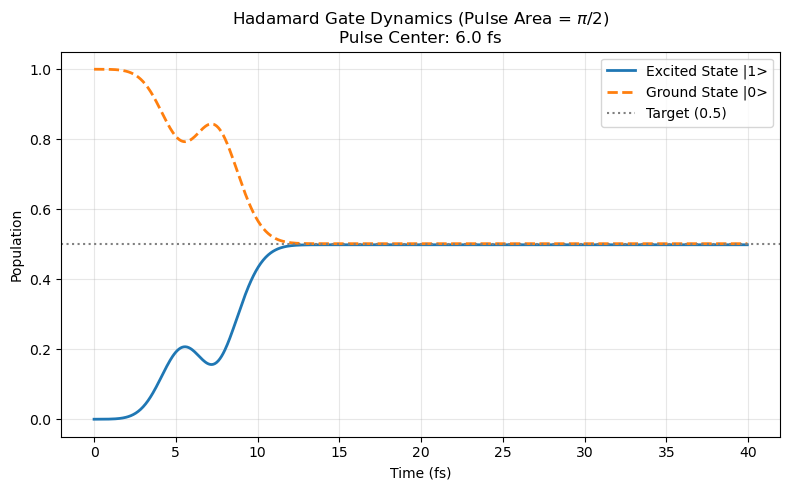

In [ ]:
import matplotlib.pyplot as plt
data = np.loadtxt(f"laser_example.dat.log", dtype=np.complex128)
# Extract real parts for Time and Populations
t_plot = data[:, 0].real
pop_exc = data[:, 1].real
coh_eg = data[:, 2]
coh_ge = data[:, 3]
pop_gnd = data[:, 4].real

print(f"\nFinal Population Excited: {pop_exc[-1]:.4f}")
print(f"Final Population Ground: {pop_gnd[-1]:.4f}")
# --- Plotting ---
plt.figure(figsize=(8, 5))
plt.plot(t_plot, pop_exc, label='Excited State |1>', linewidth=2)
plt.plot(t_plot, pop_gnd, '--', label='Ground State |0>', linewidth=2)

# Mark the 0.5 target
plt.axhline(0.5, color='gray', linestyle=':', label='Target (0.5)')

plt.xlabel('Time (fs)')
plt.ylabel('Population')
plt.title(f'Hadamard Gate Dynamics (Pulse Area = $\pi/2$)\nPulse Center: {t0_fs} fs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{'laser_example'}_population_plot.png", dpi=300, transparent=True)
plt.show()



<>:34: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
<>:34: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
/var/folders/_3/vb4hn5kx53qdsd55_fkc4lhm0000gn/T/ipykernel_249/761723630.py:34: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
  ax1.set_title(f'Hadamard Gate Dynamics (Pulse Area = $\pi/2$)\nPulse Center: {t0_fs} fs')



Final Population Excited: 0.4985
Final Population Ground: 0.5015


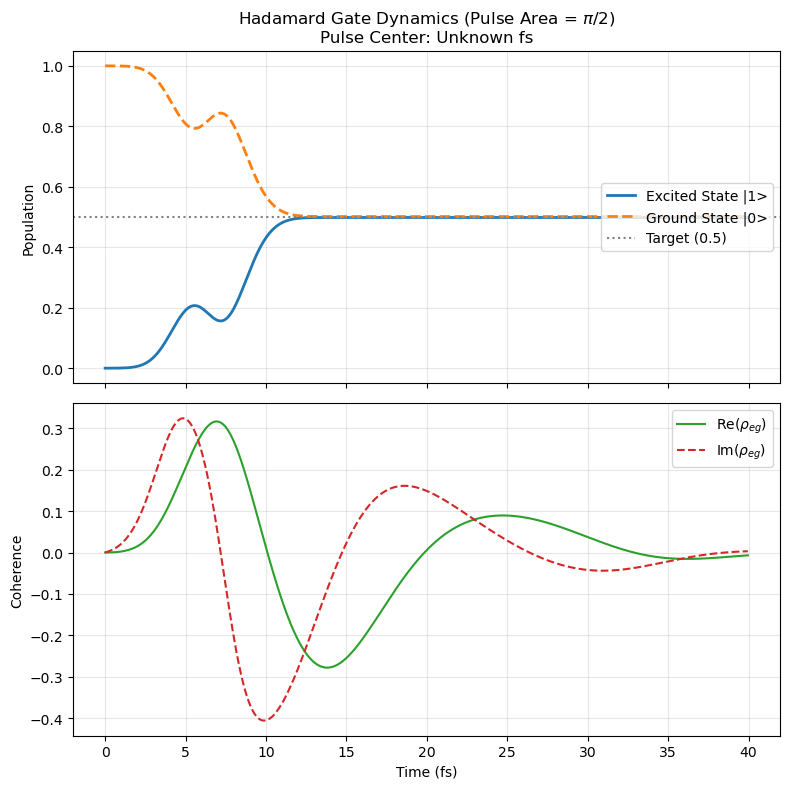

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Load data
# Ensure the file exists, or this line will raise an error
data = np.loadtxt(f"laser_example.dat.log", dtype=np.complex128)

# Extract real parts for Time and Populations
t_plot = data[:, 0].real
pop_exc = data[:, 1].real
coh_eg = data[:, 2]        # This is complex
coh_ge = data[:, 3]        # This is complex
pop_gnd = data[:, 4].real

# Check if t0_fs is defined (for the title), otherwise set a default to avoid errors
if 't0_fs' not in locals():
    t0_fs = "Unknown"

print(f"\nFinal Population Excited: {pop_exc[-1]:.4f}")
print(f"Final Population Ground: {pop_gnd[-1]:.4f}")

# --- Plotting ---
# Create 2 vertical subplots, sharing the X axis (time)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# === Upper Panel: Populations ===
ax1.plot(t_plot, pop_exc, label='Excited State |1>', linewidth=2, color='tab:blue')
ax1.plot(t_plot, pop_gnd, '--', label='Ground State |0>', linewidth=2, color='tab:orange')

# Mark the 0.5 target
ax1.axhline(0.5, color='gray', linestyle=':', label='Target (0.5)')

ax1.set_ylabel('Population')
ax1.set_title(f'Hadamard Gate Dynamics (Pulse Area = $\pi/2$)\nPulse Center: {t0_fs} fs')
ax1.legend(loc='center right')
ax1.grid(True, alpha=0.3)

# === Lower Panel: Coherences ===
# Since coherence is complex, we usually plot Real and Imaginary parts
ax2.plot(t_plot, np.real(coh_eg), label='Re($\\rho_{eg}$)', linewidth=1.5, color='tab:green')
ax2.plot(t_plot, np.imag(coh_eg), '--', label='Im($\\rho_{eg}$)', linewidth=1.5, color='tab:red')

# Optional: Plot the magnitude (absolute value) if needed
# ax2.plot(t_plot, np.abs(coh_eg), 'k:', label='|$\\rho_{eg}$|', alpha=0.5)

ax2.set_ylabel('Coherence')
ax2.set_xlabel('Time (fs)')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("laser_example_population_plot.png", dpi=300, transparent=True)
plt.show()

<>:34: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
<>:34: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
/var/folders/_3/vb4hn5kx53qdsd55_fkc4lhm0000gn/T/ipykernel_249/1934538737.py:34: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
  ax1.set_title(f'Hadamard Gate Dynamics (Pulse Area = $\pi/2$)\nPulse Center: {t0_fs} fs')



Final Population Excited: 0.4985
Final Population Ground: 0.5015


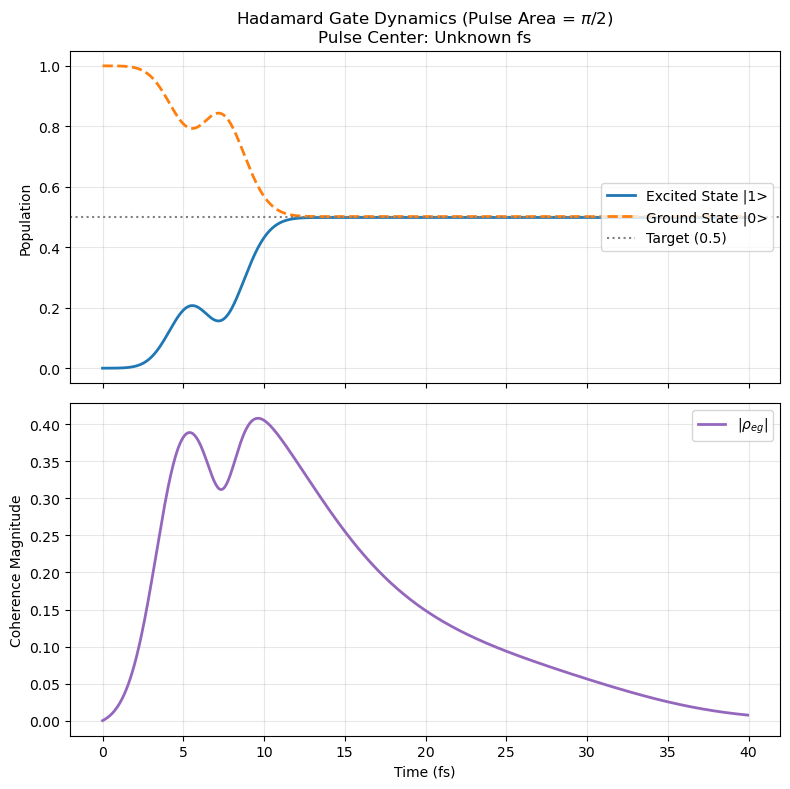

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Load data
# Ensure the file exists, or this line will raise an error
data = np.loadtxt(f"laser_example.dat.log", dtype=np.complex128)

# Extract real parts for Time and Populations
t_plot = data[:, 0].real
pop_exc = data[:, 1].real
coh_eg = data[:, 2]        # Complex number
coh_ge = data[:, 3]        # Complex number
pop_gnd = data[:, 4].real

# Check if t0_fs is defined (for the title), otherwise set a default
if 't0_fs' not in locals():
    t0_fs = "Unknown"

print(f"\nFinal Population Excited: {pop_exc[-1]:.4f}")
print(f"Final Population Ground: {pop_gnd[-1]:.4f}")

# --- Plotting ---
# Create 2 vertical subplots, sharing the X axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# === Upper Panel: Populations ===
ax1.plot(t_plot, pop_exc, label='Excited State |1>', linewidth=2, color='tab:blue')
ax1.plot(t_plot, pop_gnd, '--', label='Ground State |0>', linewidth=2, color='tab:orange')

# Mark the 0.5 target
ax1.axhline(0.5, color='gray', linestyle=':', label='Target (0.5)')

ax1.set_ylabel('Population')
ax1.set_title(f'Hadamard Gate Dynamics (Pulse Area = $\pi/2$)\nPulse Center: {t0_fs} fs')
ax1.legend(loc='center right')
ax1.grid(True, alpha=0.3)

# === Lower Panel: Coherence Modulus ===
# Calculate the absolute value (magnitude)
coh_mag = np.abs(coh_eg)

ax2.plot(t_plot, coh_mag, label=r'$|\rho_{eg}|$', linewidth=2, color='tab:purple')

ax2.set_ylabel('Coherence Magnitude')
ax2.set_xlabel('Time (fs)')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save and Show
plt.savefig("laser_example_population_plot.png", dpi=300, transparent=True)
plt.show()